In [144]:
! pip install torch_geometric networkx matplotlib torch torchvision torch-geometric torchsummary layers

In [145]:
import json
from torchsummary import summary
import os
import networkx as nx
import torch
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.utils.data import random_split

In [146]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [147]:
# function to load json
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# make graph
def build_graph(data):
    G = nx.DiGraph()

    # add  root tweet
    root_id = data['id']
    G.add_node(root_id, **data)
    
    # recursive function to add children
    def add_children(children, parent_id):
        for child in children:
            G.add_node(child['id'], **child)
            G.add_edge(parent_id, child['id'])
            if 'children' in child:
                add_children(child['children'], child['id'])
    
    if 'children' in data:
        add_children(data['children'], root_id)
    
    return G


# function to normalize node attributes
def normalize_node_attributes(graph):
    all_attributes = set()
    for _, attrs in graph.nodes(data=True):
        all_attributes.update(attrs.keys())
    for node, attrs in graph.nodes(data=True):
        for attr in all_attributes:
            if attr not in attrs:
                attrs[attr] = None
    return graph


# adjusted convert to data
# added node degree and clustering coefficient as node features
def convert_to_data(graph, label):
    data = from_networkx(graph)
    
    # give more informative signals than all ones
    if not hasattr(data, 'x') or data.x is None:
        num_nodes = data.num_nodes
        degrees = torch.tensor([degree for _, degree in graph.degree()], dtype=torch.float).view(-1, 1)
        clustering = torch.tensor([nx.clustering(graph, node) for node in graph.nodes], dtype=torch.float).view(-1, 1)
        data.x = torch.cat([degrees, clustering], dim=1)
    
    data.y = torch.tensor([label] * data.num_nodes, dtype=torch.long)
    return data


path = '/kaggle/input/test-network/nx_network_data/' # change to individual path


def create_json_dict(base_path):
    json_dict = {}
    
    for label in ['gossipcop_fake', 'gossipcop_real']:
        folder_path = os.path.join(base_path, label)
        files = os.listdir(folder_path)
        files = [f for f in files if f.endswith('.json')]
        for file in files:  
            json_dict[os.path.join(label, file)] = 'fake' if label == 'gossipcop_fake' else 'real'
    
    return json_dict

json_dict = create_json_dict(path)

full_dataset = []

# loop to create mega dataset
for dataset in list(json_dict.keys()):
    file = load_json(path + dataset)
    graph = normalize_node_attributes(build_graph(file))
    data = convert_to_data(graph, 1) if json_dict[dataset] == 'fake' else convert_to_data(graph, 0)
    full_dataset.append(data)


In [148]:
len(full_dataset)

10629

Number of Graphs: 10629
Number of fake news graphs: 3684
Number of real news graphs: 6945


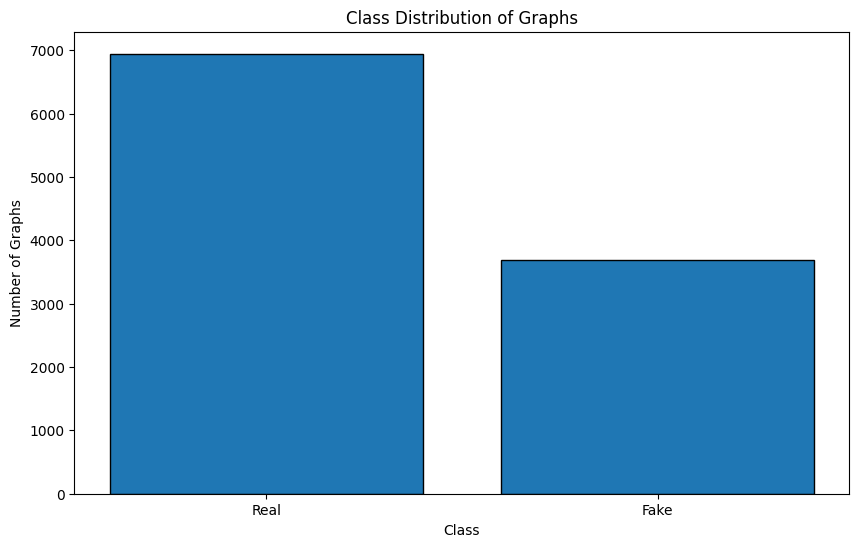

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of fake and real news graphs
fake_count = 0
real_count = 0

for data in full_dataset:
    label = data.y[0].item()  # Get the label for the first node
    if label == 1:
        fake_count += 1
    elif label == 0:
        real_count += 1

# Print the counts
print(f'Number of Graphs: {len(full_dataset)}')
print(f'Number of fake news graphs: {fake_count}')
print(f'Number of real news graphs: {real_count}')

# Prepare data for histogram
labels = [0] * real_count + [1] * fake_count
label_names = ['Real', 'Fake']

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(labels, bins=np.arange(-0.5, 2, 1), edgecolor='black', rwidth=0.8)
plt.xticks([0, 1], label_names)
plt.xlabel('Class')
plt.ylabel('Number of Graphs')
plt.title('Class Distribution of Graphs')
plt.show()


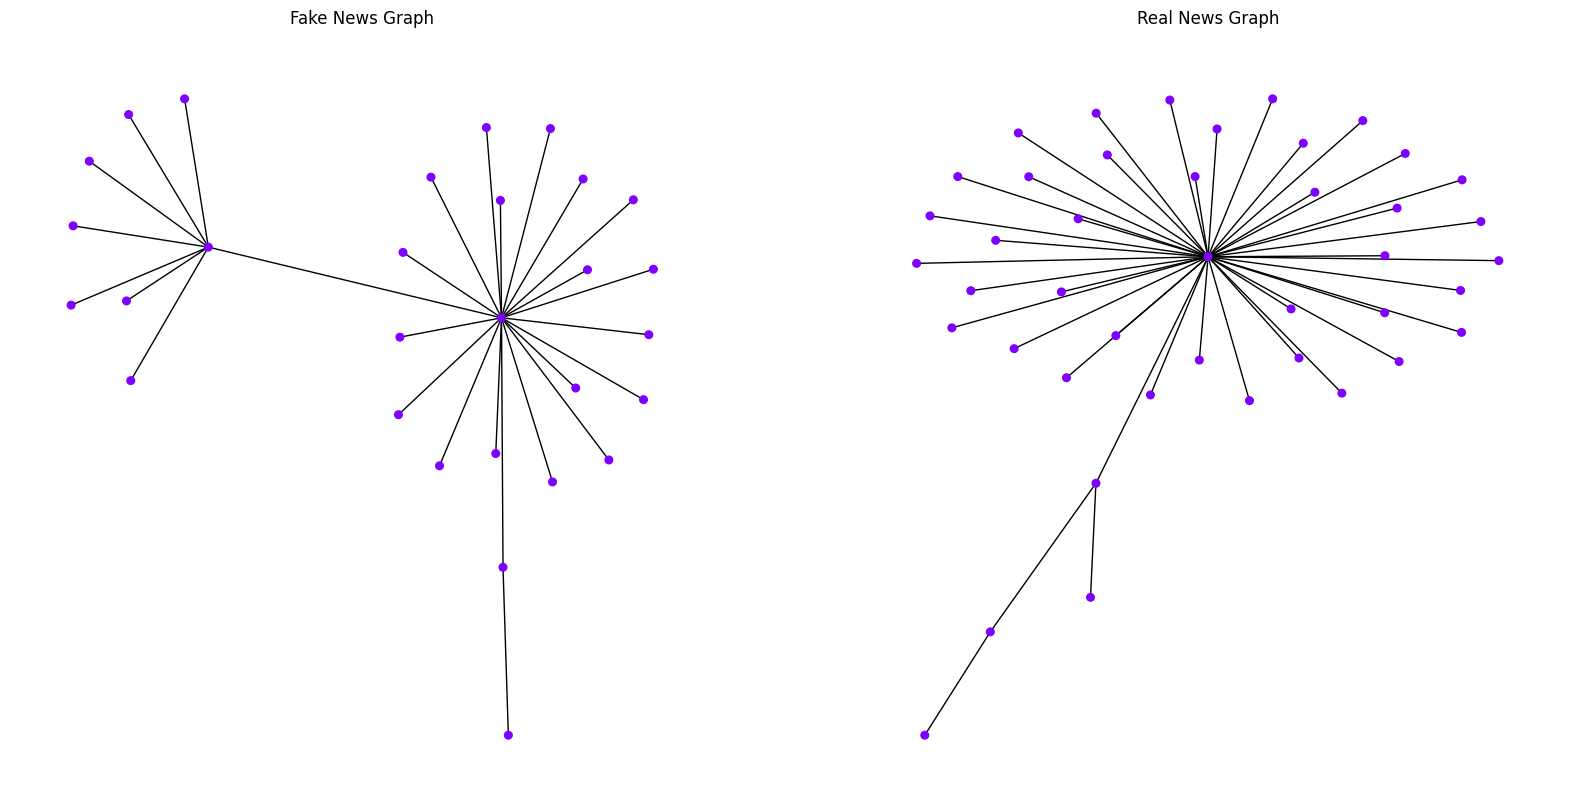

In [150]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Find one fake news graph and one real news graph
fake_data = next(data for data in full_dataset if data.y[0].item() == 1)
real_data = next(data for data in full_dataset if data.y[0].item() == 0)

# Convert to NetworkX graphs and find their largest connected components
def get_largest_wcc(data):
    G = to_networkx(data, to_undirected=True)
    largest_wcc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_wcc).copy()

G_fake = get_largest_wcc(fake_data)
G_real = get_largest_wcc(real_data)

# Define the layout for both graphs
pos_fake = nx.spring_layout(G_fake)
pos_real = nx.spring_layout(G_real)

# Create a figure with two subplots
plt.figure(figsize=(20, 10))

# Plot fake news graph
plt.subplot(1, 2, 1)
nx.draw(
    G_fake, 
    pos_fake, 
    node_size=30, 
    node_color=[fake_data.y[i].item() for i in G_fake.nodes()],
    cmap=plt.cm.rainbow, 
    with_labels=False, 
    arrows=True
)
plt.title('Fake News Graph')

# Plot real news graph
plt.subplot(1, 2, 2)
nx.draw(
    G_real, 
    pos_real, 
    node_size=30, 
    node_color=[real_data.y[i].item() for i in G_real.nodes()],
    cmap=plt.cm.rainbow, 
    with_labels=False, 
    arrows=True
)
plt.title('Real News Graph')

# Show the plot
plt.show()

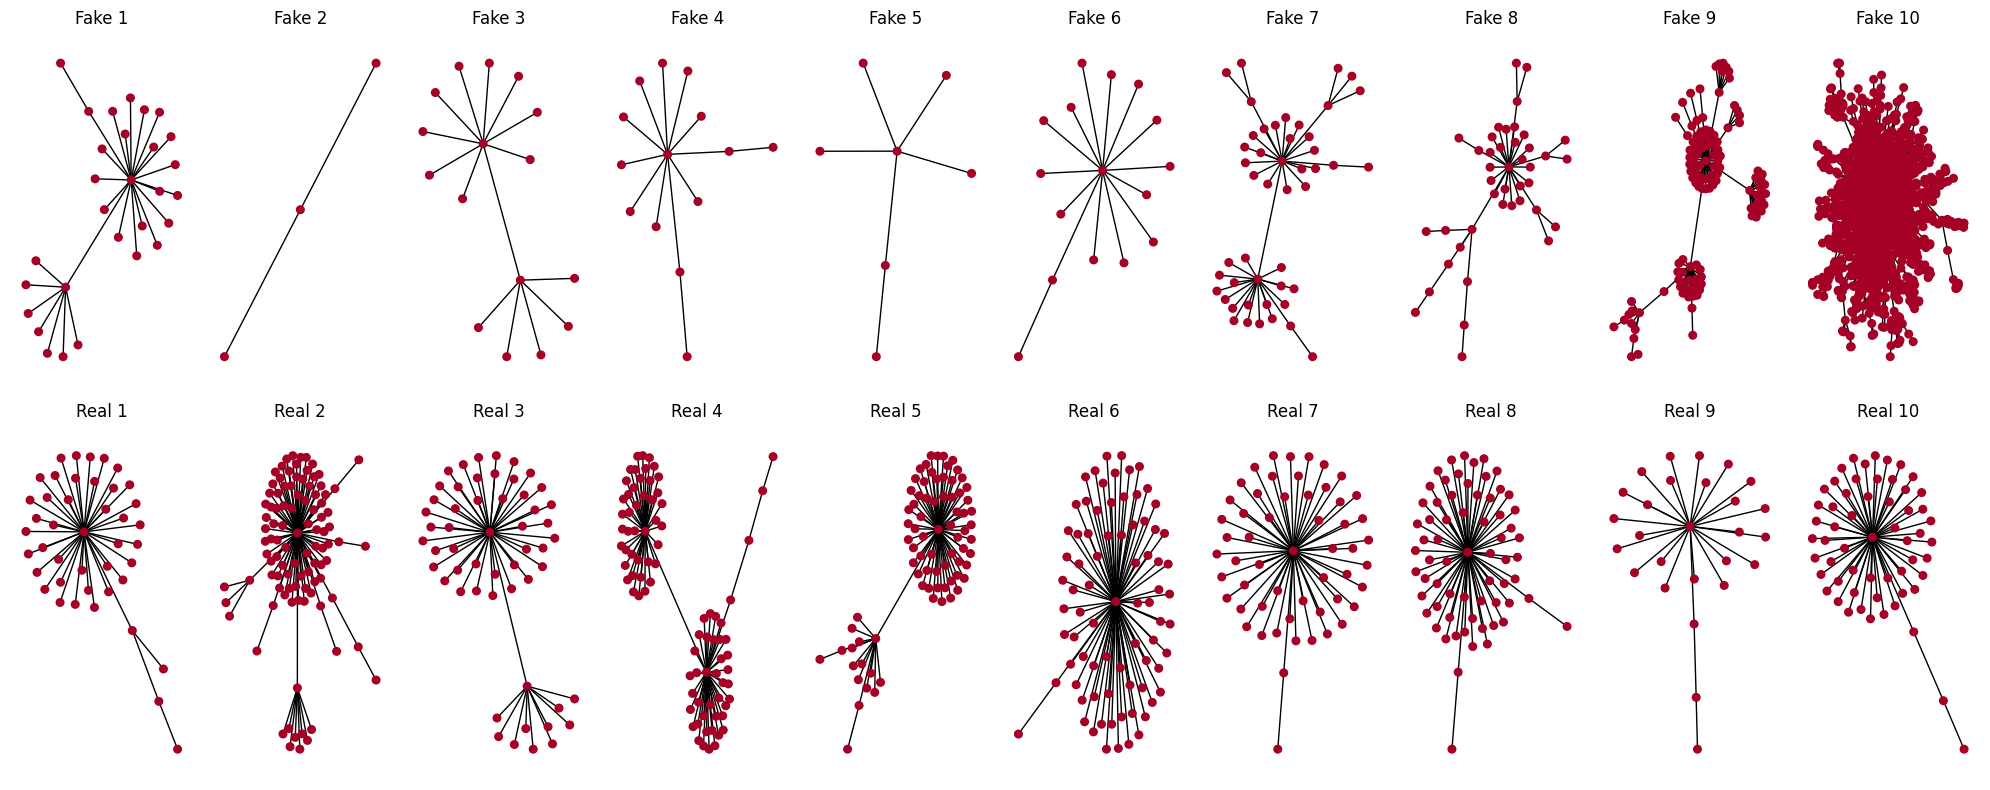

In [151]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Extract 10 fake and 10 real news graphs from the dataset
fake_graphs = [data for data in full_dataset if data.y[0].item() == 1][:10]
real_graphs = [data for data in full_dataset if data.y[0].item() == 0][:10]

# Create a figure with subplots
fig, axs = plt.subplots(2, 10, figsize=(20, 8))  # Adjust figsize as needed

# Define layout for plotting
for i, (fake_data, real_data) in enumerate(zip(fake_graphs, real_graphs)):
    # Plot fake news graph
    G_fake = to_networkx(fake_data, to_undirected=True)
    pos_fake = nx.spring_layout(G_fake, seed=42)
    nx.draw(
        G_fake,
        pos_fake,
        ax=axs[0, i],
        node_size=30,
        node_color=[fake_data.y[i].item() for i in G_fake.nodes()],
        cmap=plt.cm.RdYlBu,
        with_labels=False,
        arrows=False
    )
    axs[0, i].set_title(f'Fake {i+1}')
    axs[0, i].axis('off')  # Hide axes

    # Plot real news graph
    G_real = to_networkx(real_data, to_undirected=True)
    pos_real = nx.spring_layout(G_real, seed=42)
    nx.draw(
        G_real,
        pos_real,
        ax=axs[1, i],
        node_size=30,
        node_color=[real_data.y[i].item() for i in G_real.nodes()],
        cmap=plt.cm.RdYlBu,
        with_labels=False,
        arrows=False
    )
    axs[1, i].set_title(f'Real {i+1}')
    axs[1, i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [152]:
import pandas as pd
import torch

def create_dataframe_from_data(data):
    # Convert each attribute to a list or numpy array if needed
    # Handle edge_index
    edge_index = data.edge_index.numpy().T.tolist()  # Transpose and convert to list of lists
    
    # Handle time
    if isinstance(data.time, torch.Tensor):
        time = data.time.numpy().tolist()
    elif isinstance(data.time, list):
        time = data.time
    else:
        time = []
    
    # Handle type
    if isinstance(data.type, torch.Tensor):
        type_ = data.type.numpy().tolist()
    elif isinstance(data.type, list):
        type_ = data.type
    else:
        type_ = []
    
    # Handle user
    if isinstance(data.user, torch.Tensor):
        user = data.user.numpy().tolist()
    elif isinstance(data.user, list):
        user = data.user
    else:
        user = []
    
    # Handle tweet_id
    if isinstance(data.tweet_id, torch.Tensor):
        tweet_id = data.tweet_id.numpy().tolist()
    elif isinstance(data.tweet_id, list):
        tweet_id = data.tweet_id
    else:
        tweet_id = []
    
    # Convert lists to DataFrames
    edge_index_df = pd.DataFrame(edge_index, columns=['Source', 'Target'])
    time_df = pd.DataFrame(time, columns=['Time'])
    type_df = pd.DataFrame(type_, columns=['Type'])
    user_df = pd.DataFrame(user, columns=['User'])
    tweet_id_df = pd.DataFrame(tweet_id, columns=['Tweet ID'])
    
    # Join all DataFrames on the index
    dataframe = pd.concat([edge_index_df, time_df, type_df, user_df, tweet_id_df], axis=1)
    
    return dataframe

# Example usage:
data1 = full_dataset[0]
dataframe = create_dataframe_from_data(data1)
dataframe

,Source,Target,Time,Type,User,Tweet ID
0,0.0,1.0,NaN,1,3849187751,gossipcop-255832279
1,0.0,2.0,1.522505e+09,2,2163053027,980081060452229120
2,0.0,3.0,1.522505e+09,2,9836646590,980081368901316608
3,0.0,11.0,1.522505e+09,2,5885428749,980081845751697408
4,0.0,12.0,1.522530e+09,3,8196947730,980082763759017984
5,0.0,13.0,1.522544e+09,3,3056777310,980139484573560832
6,0.0,14.0,1.522546e+09,3,8741307729,980148159451156480
7,0.0,15.0,1.522509e+09,4,7874711732,980099251555336193
8,0.0,16.0,1.522507e+09,4,7628520219,980093227247190017
9,0.0,17.0,1.522505e+09,4,7009781084,980082386166800384


In [153]:
import random

fake_news_data = [data for data in full_dataset if data.y[0].item() == 1]
real_news_data = [data for data in full_dataset if data.y[0].item() == 0]

balanced_full_dataset = fake_news_data + random.choices(fake_news_data, k=len(real_news_data) - len(fake_news_data)) + real_news_data
random.shuffle(balanced_full_dataset)


train_size = int(0.7 * len(balanced_full_dataset))
val_size = int(0.15 * len(balanced_full_dataset))
test_size = len(balanced_full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(balanced_full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)



class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(0.5)  # added dropout layer

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [154]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

In [ ]:
def train_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, device, checkpoint_path):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data.x, data.edge_index)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data.x, data.edge_index)
                loss = criterion(output, data.y)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    model.load_state_dict(torch.load(checkpoint_path))
    return train_losses, val_losses

Epoch: 1, Training Loss: 5.6711, Validation Loss: 0.7186
Validation loss decreased (748.786959 --> 748.786959).  Saving model ...
Epoch: 2, Training Loss: 0.6692, Validation Loss: 0.6152
Validation loss decreased (748.786959 --> 641.004890).  Saving model ...
Epoch: 3, Training Loss: 0.6207, Validation Loss: 0.5688
Validation loss decreased (641.004890 --> 592.725672).  Saving model ...
Epoch: 4, Training Loss: 0.6288, Validation Loss: 0.6261
Epoch: 5, Training Loss: 0.6490, Validation Loss: 0.6226
Epoch: 6, Training Loss: 0.6492, Validation Loss: 0.6267
Epoch: 7, Training Loss: 0.6426, Validation Loss: 0.6086
Epoch: 8, Training Loss: 0.6272, Validation Loss: 0.5771
Epoch: 9, Training Loss: 0.6102, Validation Loss: 0.5557
Validation loss decreased (592.725672 --> 579.088194).  Saving model ...
Epoch: 10, Training Loss: 0.6174, Validation Loss: 0.5627


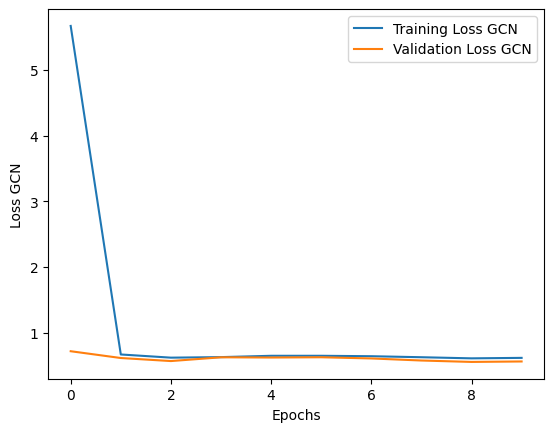

In [155]:
import torch.optim as optim

# Initialize the model, optimizer, and loss function
input_dimensions = 2 # is two due to additional feature of level of retweet
hidden_dimensions = 16
output_dimensions = 2
gcn_model = GCN(in_channels=input_dimensions, hidden_channels=hidden_dimensions, out_channels=output_dimensions)
optimizer = optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

# Initialize early stopping
early_stopper = EarlyStopping(patience=25, min_delta=0.0001, path='gnn_checkpoint.pt')

# Move model to device
gcn_model.to(device)

# Train the GNN model
epochs = 10
train_losses_gcn, val_losses_gcn = train_model(epochs, gcn_model, optimizer, criterion, train_loader, val_loader, early_stopper, device, 'gnn_checkpoint.pt')

# Plot training and validation losses
plt.plot(train_losses_gcn, label='Training Loss GCN')
plt.plot(val_losses_gcn, label='Validation Loss GCN')
plt.xlabel('Epochs')
plt.ylabel('Loss GCN')
plt.legend()
plt.show()

In [162]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import torch_geometric.transforms as T


class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_heads, out_channels, dropout=0.4):
        super(GAT, self).__init__()
        
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, dropout=dropout, concat=True)
        self.gat2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, dropout=dropout, concat=False)
    
    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)  # ELU activation function
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Log softmax activation function

# Define model parameters
in_channels = 2
hidden_channels = 16
num_heads = 4
out_channels = 2
dropout = 0.4

# Initialize the model
gat_model = GAT(in_channels, hidden_channels, num_heads, out_channels, dropout)
gat_model.to(device)


# Define optimizer and loss function
optimizer_gat = torch.optim.Adam(gat_model.parameters(), lr=0.01)
criterion_gat = nn.CrossEntropyLoss()

# Print model summary
print(gat_model)

GAT(
  (gat1): GATConv(2, 16, heads=4)
  (gat2): GATConv(64, 2, heads=1)
)


Epoch: 1, Training Loss: 1.0682, Validation Loss: 0.6397
Validation loss decreased (666.565853 --> 666.565853).  Saving model ...
Epoch: 2, Training Loss: 0.6757, Validation Loss: 0.5990
Validation loss decreased (666.565853 --> 624.112992).  Saving model ...
Epoch: 3, Training Loss: 0.6871, Validation Loss: 0.6324
Epoch: 4, Training Loss: 0.7086, Validation Loss: 0.6714
Epoch: 5, Training Loss: 0.6971, Validation Loss: 0.7389
Epoch: 6, Training Loss: 0.6912, Validation Loss: 0.6836
Epoch: 7, Training Loss: 0.6866, Validation Loss: 0.6268
Epoch: 8, Training Loss: 0.6904, Validation Loss: 0.6249
Epoch: 9, Training Loss: 0.6985, Validation Loss: 0.6166
Epoch: 10, Training Loss: 0.6870, Validation Loss: 0.6448


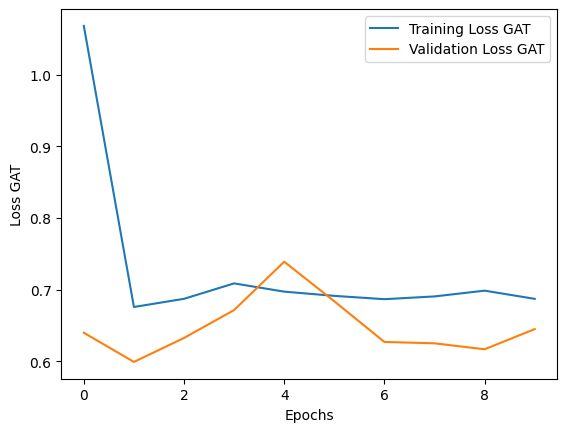

In [163]:
import torch
import torch.optim as optim
import torch.nn as nn


# Initialize early stopping for GAT model
early_stopper_gat = EarlyStopping(patience=25, min_delta=0.0001, path='gat_checkpoint.pt')

train_losses_gat, val_losses_gat = train_model(epochs, gat_model, optimizer_gat, criterion_gat, train_loader, val_loader, early_stopper_gat, device, 'gat_checkpoint.pt')

# Plot training and validation losses
plt.plot(train_losses_gat, label='Training Loss GAT')
plt.plot(val_losses_gat, label='Validation Loss GAT')
plt.xlabel('Epochs')
plt.ylabel('Loss GAT')
plt.legend()
plt.show()

In [164]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(data_loader, model, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            inputs, edge_index = data.x, data.edge_index  # Get inputs and edge_index from the data
            outputs = model(inputs, edge_index)  # Pass both to the model
            
            if isinstance(outputs, tuple):
                outputs = outputs[0] 
            _, predicted = torch.max(outputs, 1) 
            y_preds.extend(predicted.cpu().numpy()) 
            y_true.extend(data.y.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_preds)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_true, y_preds, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_preds))

    return accuracy

# Evaluate GNN model on validation set
print("\n---------------GCN MODEL (Validation)---------------\n")
gcn_val_accuracy = evaluate_model(val_loader, gcn_model, device)

# Evaluate GNN model on test set
print("\n---------------GCN MODEL (Test)---------------\n")
gcn_test_accuracy = evaluate_model(test_loader, gcn_model, device)


---------------GCN MODEL (Validation)---------------

Accuracy: 0.8361526036492177
Classification Report:
               precision    recall  f1-score   support

           0     0.7164    0.6582    0.6861    125133
           1     0.8760    0.9026    0.8891    334856

    accuracy                         0.8362    459989
   macro avg     0.7962    0.7804    0.7876    459989
weighted avg     0.8326    0.8362    0.8339    459989

Confusion Matrix:
 [[ 82364  42769]
 [ 32599 302257]]

---------------GCN MODEL (Test)---------------

Accuracy: 0.8350789373165322
Classification Report:
               precision    recall  f1-score   support

           0     0.6811    0.6792    0.6801    122332
           1     0.8885    0.8893    0.8889    351525

    accuracy                         0.8351    473857
   macro avg     0.7848    0.7843    0.7845    473857
weighted avg     0.8349    0.8351    0.8350    473857

Confusion Matrix:
 [[ 83086  39246]
 [ 38903 312622]]


In [165]:
print("\n---------------GAT MODEL (Validation)---------------\n")
gat_val_accuracy = evaluate_model(val_loader, gat_model, device)

# Evaluate GNN model on test set
print("\n---------------GAT MODEL (Test)---------------\n")
gat_test_accuracy = evaluate_model(test_loader, gat_model, device)


---------------GAT MODEL (Validation)---------------

Accuracy: 0.5355345453913029
Classification Report:
               precision    recall  f1-score   support

           0     0.3475    0.8059    0.4856    125133
           1     0.8570    0.4345    0.5766    334856

    accuracy                         0.5355    459989
   macro avg     0.6022    0.6202    0.5311    459989
weighted avg     0.7184    0.5355    0.5519    459989

Confusion Matrix:
 [[100848  24285]
 [189364 145492]]

---------------GAT MODEL (Test)---------------

Accuracy: 0.5434149965073851
Classification Report:
               precision    recall  f1-score   support

           0     0.3369    0.7937    0.4730    122332
           1     0.8641    0.4563    0.5972    351525

    accuracy                         0.5434    473857
   macro avg     0.6005    0.6250    0.5351    473857
weighted avg     0.7280    0.5434    0.5652    473857

Confusion Matrix:
 [[ 97094  25238]
 [191118 160407]]
